In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas             as pd

import scipy
from scipy import stats, integrate
import os

import tables             as tb

In [96]:
import time
t0 = time.perf_counter()

# Global parameters

In [97]:
signal = np.zeros(2)

"""
ch = 1: Trigger
ch = 2: SiPM signal

fib = 0: NO
fib = 1: YES
"""
detect = ['index', 'trigger', 'SiPM'] 

ch = 2

fibers = [' without fibers', ' with fibers']
n_fibers = 36

# baseline_corrected = True
baseline_corrected = False

# integr_method = 'integrate around the peak'
# integr_method = 'integrate in a fixed window t1-t2'  
integr_method = 'integrate ALL waveform'

In [98]:
detect

['index', 'trigger', 'SiPM']

# Data

In [99]:
filename = ['', '', '']

path = '/home/investigator/mariandbt/python/data'
path = path + '/20231124_eff_study'

filename[0] = os.path.join(path, 'fiber_eff_no_epoxy_LED.h5') # W/O fibers
filename[1] = os.path.join(path, 'fibers_eff_no_epoxy_fibers_readout_grease.h5') # WITH fibers
filename[2] = os.path.join(path, 'fiber_no_epoxy_baseline.h5') # baseline



In [101]:
# with tb.open_file(filename[2]) as file:
#     print(file)

/home/investigator/mariandbt/python/data/20231124_eff_study/fiber_no_epoxy_baseline.h5 (File) ''
Last modif.: '2023-11-23T09:17:49+00:00'
Object Tree: 
/ (RootGroup) ''
/events (Group) 'Events'
/events/event_1 (Group) 'Event 1'
/events/event_1/time (Array(2500,)) ''
/events/event_1/voltage_ch1 (Array(2500,)) ''
/events/event_1/voltage_ch2 (Array(2500,)) ''
/events/event_10 (Group) 'Event 10'
/events/event_10/time (Array(2500,)) ''
/events/event_10/voltage_ch1 (Array(2500,)) ''
/events/event_10/voltage_ch2 (Array(2500,)) ''
/events/event_100 (Group) 'Event 100'
/events/event_100/time (Array(2500,)) ''
/events/event_100/voltage_ch1 (Array(2500,)) ''
/events/event_100/voltage_ch2 (Array(2500,)) ''
/events/event_1000 (Group) 'Event 1000'
/events/event_1000/time (Array(2500,)) ''
/events/event_1000/voltage_ch1 (Array(2500,)) ''
/events/event_1000/voltage_ch2 (Array(2500,)) ''
/events/event_1001 (Group) 'Event 1001'
/events/event_1001/time (Array(2500,)) ''
/events/event_1001/voltage_ch1 (Ar

In [105]:
a = tb.open_file(filename[2], 'r')

data = pd.DataFrame([])

for i in range(1, 5):
    event_group_name = f'event_{i}'
    ev_id = i
    time = getattr(getattr(a.root.events, event_group_name), 'time')[:]
    voltage_ch1 = getattr(getattr(a.root.events, event_group_name), 'voltage_ch2')[:]
    voltage_ch2 = getattr(getattr(a.root.events, event_group_name), 'voltage_ch1')[:]
    
    # Create a new DataFrame from the array
    new_rows = pd.DataFrame({'event_id': ev_id,
                             'time' : time,
                             'voltage_ch1' : voltage_ch1,
                             'voltage_ch2' : voltage_ch2
                            })
    
    data = data.append(new_rows, ignore_index=True)
    
a.close()

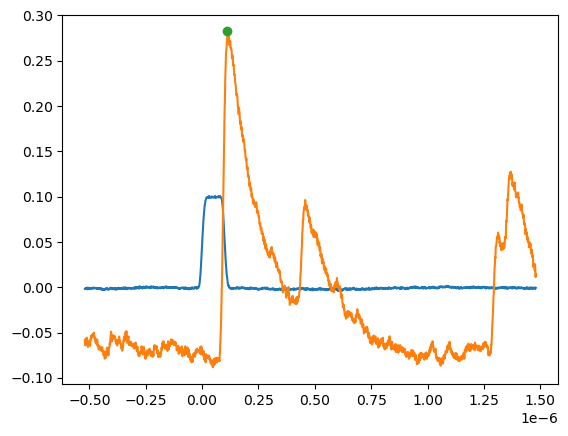

In [120]:
ev = 2

tt = data.loc[data.event_id == ev].time
signal = data.loc[data.event_id == ev].voltage_ch1
trigger = data.loc[data.event_id == ev].voltage_ch2

plt.plot(tt, trigger)
plt.plot(tt, signal)
plt.plot(t_peak, v_peak, 'o')


# Waveform identification

In [114]:
waveform = data.loc[data.event_id == ev]

In [115]:
peak = waveform.loc[(waveform.time > 0.) & (waveform.time < 0.5e-6)]

t_peak = peak.loc[peak.voltage_ch1 == peak.voltage_ch1.max()].time.values
v_peak = peak.loc[peak.voltage_ch1 == peak.voltage_ch1.max()].voltage_ch1.values


In [116]:
data.voltage_ch1 - v_peak

0      -0.356094
1      -0.354141
2      -0.355234
3      -0.353437
4      -0.352812
          ...   
9995   -0.333516
9996   -0.331797
9997   -0.329609
9998   -0.332031
9999   -0.334297
Name: voltage_ch1, Length: 10000, dtype: float64

In [118]:
peak = waveform.loc[(np.fabs(waveform.time - t_peak) < 0.1e-6)]

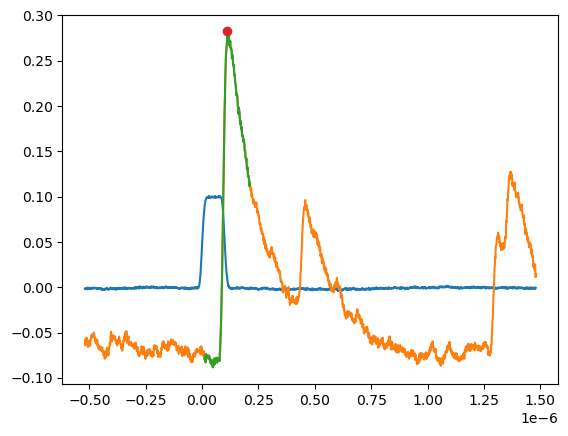

In [119]:
plt.plot(tt, trigger)
plt.plot(tt, signal)
plt.plot(peak.time, peak.voltage_ch1)
plt.plot(t_peak, v_peak, 'o')


# Functions

In [6]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

n_pe = 2

# Super LOOP

PMT without fibers
Amplification =  1.04
Mean value =  2.63
Std = 0.06 

PMT with fibers
Amplification =  1.04
Mean value =  0.96
Std = 0.03 



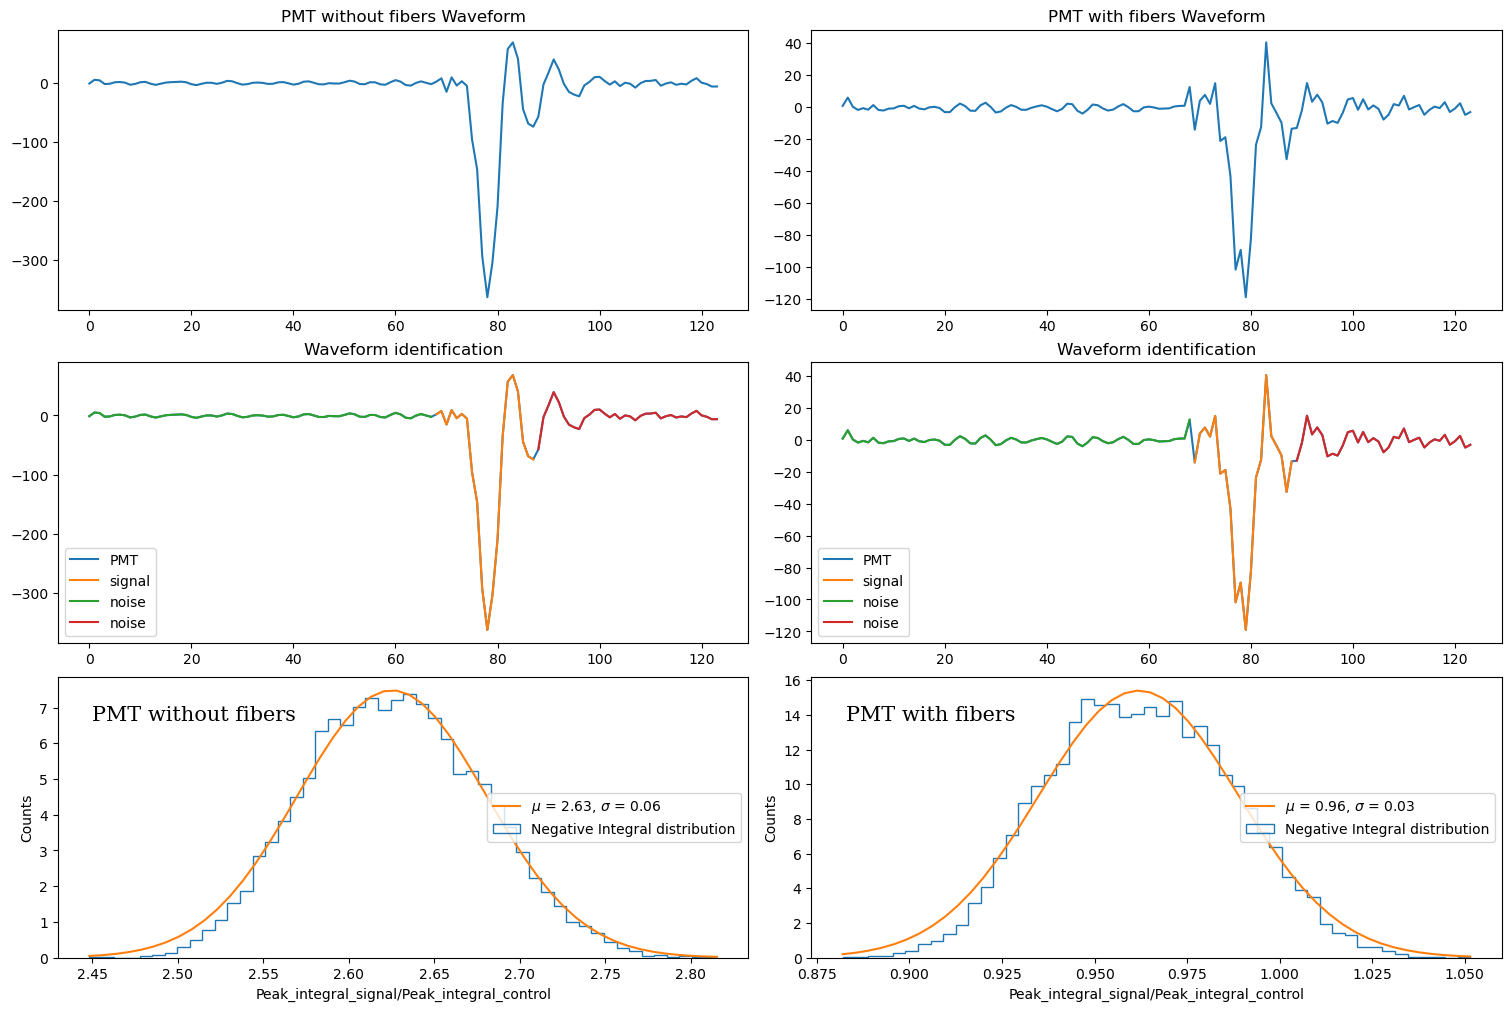

In [7]:
%%timeit
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,10), constrained_layout=True)

for fib in [0, 1]:
    #____________________________________________________________________________________________________________________
    #_________________________________Data_______________________________________________________________________________
    #____________________________________________________________________________________________________________________

    data = []
    with open(filename[fib],'r', encoding='ascii') as fp:
        for i, line in enumerate(fp):
            if any(c.isalpha() for c in line) == False:
                data.append(np.asarray(line.split('\t')[:-1], dtype=float))
    fp.close()

    waveform = np.array(data)


    n_points = int(waveform[:, 0].max() + 1)
    n_frames = int(len(waveform)/n_points) 



    #____________________________________________________________________________________________________________________
    #_________________________________Waveform___________________________________________________________________________
    #____________________________________________________________________________________________________________________

    frame = int(n_frames/2); 
    # print('frame = ', frame)

    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
    x_ax = wave[:, 0]

    #_______________________________________________________________________________

    t1 = 70
    t2 = 90
#     t1 = 150
#     t2 = 200
#     t1 = 0
#     t2 = 1000

    dt_izq = 10
    dt_dch = 10

    #_______________________________________________________________________________

    t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])

    pre_base = wave[:, ch][:t0 - dt_izq]
    x_ax_pre = x_ax[:t0 - dt_izq]

    peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch].copy()
    x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch].copy()

    post_base = wave[:, ch][t0 + dt_dch:]
    x_ax_post = x_ax[t0 + dt_dch:]


    #_________plot_settings_________________________________________________

#     fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)
    ax[0, 0 + fib].plot(x_ax, wave[:, ch], label = detect[ch])
    ax[0, 0 + fib].set_title(detect[ch] + fibers[fib] + ' Waveform')

#     fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)
    ax[1, 0 + fib].plot(x_ax, wave[:, ch], label = detect[ch])
    ax[1, 0 + fib].plot(x_ax_peak, peak, label='signal')
    ax[1, 0 + fib].plot(x_ax_pre, pre_base, label = 'noise')
    ax[1, 0 + fib].plot(x_ax_post, post_base, label = 'noise')
    ax[1, 0 + fib].legend(loc = 'best')
    ax[1, 0 + fib].set_title('Waveform identification')



    #____________________________________________________________________________________________________________________
    #_________________________________Integral___________________________________________________________________________
    #____________________________________________________________________________________________________________________

    peak_integr = []
    peak_integr_pos = []

    for frame in range(n_frames):


    #_________baseline_________________________________________________

        wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
        x_ax = wave[:, 0]


        t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])

        pre_base = wave[:, ch][:t0 - dt_izq].copy()
        x_ax_pre = x_ax[:t0 - dt_izq].copy()

        post_base = wave[:, ch][t0 + dt_dch:].copy()
        x_ax_post = x_ax[t0 + dt_dch:].copy()

        base = []
        base.append(pre_base.mean())
        base.append(post_base.mean())

        baseline = np.array(base).mean()
    #     print(base, baseline)

        if baseline_corrected:
            wave[:, ch] = wave[:, ch] - baseline # NOW THE WAVEFORM IS CORRECTED


    #_________integration_________________________________________________


        if integr_method == 'integrate around the peak':
            peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch].copy()
            x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch].copy()
            
            control_peak = wave[:, control_ch][t0 - dt_izq : t0 + dt_dch].copy()

            
        if integr_method == 'integrate in a fixed window t1-t2':  
            peak = wave[:, ch][t1 : t2].copy()
            x_ax_peak = x_ax[t1 : t2].copy()
            
            control_peak = wave[:, control_ch][t1 : t2].copy()
            
            
        if integr_method == 'integrate ALL waveform':
            peak = wave[:, ch].copy()
            x_ax_peak = x_ax.copy()
            
            control_peak = wave[:, control_ch].copy()


            
        integr = np.trapz(peak, x=x_ax_peak)
        control_integr = np.trapz(control_peak, x=x_ax_peak)

        peak_integr.append(integr/control_integr) # normalized to the control PMT
        peak_integr_pos.append([integr, frame])

    #     print(frame)

    peak_integr = np.array(peak_integr)
    peak_integr_pos = np.array(peak_integr_pos)

    # peak_integr.mean()
    # peak_integr
    # peak_integr_pos 
    
    
    
    #_________plot_settings_________________________________________________

    # fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)
    # ax.plot(x_ax, waveform[frame], label = 'calib PMT')
    # ax.plot(x_ax_pre, pre_base, label = 'PMT noise')
    # ax.plot(x_ax_post, post_base, label = 'PMT noise')
    # ax.plot(x_ax, wave, label = 'Leire\'s PMT corrected by baseline')
    # ax.plot(x_ax_peak, peak, label='signal')

    # ax.set_ylabel('mV')
    # ax.set_xlabel('Index')
    # ax.set_title('LED pulse at 1.47V, 2us, 5%df')
    # ax.text(0.05, .1, 'LED at 992mV, frame %s'%(frame), 
    #         transform=ax.transAxes, # to use (x,y) pos with relative values to the axis and not absolute data points
    #         fontsize=15, verticalalignment='top', fontfamily='serif',
    #         bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
    # ax.legend(loc = 'best')



    #____________________________________________________________________________________________________________________
    #_________________________________Integrals_distribution_____________________________________________________________
    #____________________________________________________________________________________________________________________

#     fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

    # events, bins, bars = plt.hist(peak_integr, 50, density=False, range=(-750, -550), label='Integral distribution')
    events, bins, bars = ax[2, fib].hist(peak_integr, 50, density=True, label='Negative Integral distribution', 
                                  histtype='step')
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

    # # sum of gaussians fit
   
    # popt, pcov = scipy.optimize.curve_fit(gauss_sum, x_ax, events, bounds=([0, -1, 1, 0, -1, 1], 
    #                                                                        [np.inf, 1e2, 1e2, np.inf, 1e2, 1e2])) 
    # a = np.zeros(n_pe); mu = np.zeros(n_pe); sigma = np.zeros(n_pe)

    # a[0], mu[0], sigma[0], a[1], mu[1], sigma[1] = popt
    # best_fit_line = gauss_sum(x_ax, a[0], mu[0], sigma[0], a[1], mu[1], sigma[1])

    
    # gaussian fit
    
    # popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 1], [np.inf, 3e3, 1e2])) 
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 1e2]) 

        
#     if ch == 3:
#         popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, 1300, 1e2])

    a, mu, sigma = popt
    best_fit_line = gauss(x_ax, a, mu, sigma)

    #_________plot_settings_________________________________________________

    # ax.plot(x_ax, best_fit_line, label='Sum of gaussian fit')
    # ax.plot(x_ax, gauss(x_ax, a[0], mu[0], sigma[0]), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu[0], sigma[0]))
    # ax.plot(x_ax, gauss(x_ax, a[1], mu[1], sigma[1]), '-y', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu[1], sigma[1]))
    ax[2, fib].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu, sigma))

    ax[2, fib].set_ylabel('Counts')
    ax[2, fib].set_xlabel('Peak_integral_signal/Peak_integral_control')

    ax[2, fib].text(0.05, .9, detect[ch] + fibers[fib], transform=ax[2, fib].transAxes,
                fontsize=15, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

#     ax[2, fib].legend(fontsize=10, loc='best')
    ax[2, fib].legend(fontsize=10, loc='right')

    print(detect[ch] + fibers[fib])
    print('Amplification = ', '%.2f'%(a))
    print('Mean value = ', '%.2f'%mu)
    print('Std = %.2f \n'%(sigma))

    signal[fib] = mu
    

# Efficiency

In [8]:
QE = {'LED':0.13, 'Y11':0.18} # Quantum efficiency without and with fibers

fib_area = n_fibers*36
pmt_area = 18*18

n_photon_led = signal[0]/(QE['LED']*pmt_area)
n_photon_fib = signal[1]/(QE['Y11']*fib_area)


eff = QE['Y11']*n_photon_fib/n_photon_led

In [9]:
print(detect[ch] + ' with fibers efficiency = %.2f %%'%(eff*100))
print('Baseline corrected:', baseline_corrected)
print('Integration method:', integr_method)

PMT with fibers efficiency = 1.19 %
Baseline corrected: False
Integration method: integrate ALL waveform


# Timer

In [10]:
tf = time.perf_counter()
print('Code timer: %.2f'%(tf-t0))

Code timer: 28435.03
